In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

# 加载cifar10数据集

In [ ]:
# import paddle # 导入paddle库
# import paddle.fluid as fluid
# from paddle.vision.datasets import Cifar10
# from paddle.vision.transforms import Compose, Normalize,ToTensor,ColorJitter,RandomHorizontalFlip
# import matplotlib.pyplot as plt
# from PIL import Image  

# # data_format='HWC'
# transform = Compose([ColorJitter(),RandomHorizontalFlip(),ToTensor()])

# cifar10 = Cifar10(mode='train', download=False,data_file ="data/data46154/cifar-10.tar.gz", transform=transform)
# train_loader = paddle.io.DataLoader(cifar10, batch_size=32, shuffle=True)

# cifar10 = Cifar10(mode='test', download=False,data_file ="data/data46154/cifar-10.tar.gz",transform=ToTensor())
# test_loader = paddle.io.DataLoader(cifar10, batch_size=32, shuffle=True)

# for batch_id, data in enumerate(train_loader()):
#     x_data = data[0]
#     y_data = data[1]
#     break

# print(x_data.numpy().shape)
# print(y_data.numpy().shape)

(32, 3, 32, 32)
(32,)


In [ ]:
import paddle.nn as nn
import paddle

class MyVGG16(nn.Layer):
    def __init__(self):
        super(MyVGG16, self).__init__()

        self.client = nn.Sequential(
            nn.Conv2D(3, 64, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(64, 64, kernel_size=[3, 3], padding=1),
            nn.ReLU()
        )

        self.serve = nn.Sequential(
            nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
            nn.Conv2D(64, 128, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(128, 128, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
            nn.Conv2D(128, 256, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(256, 256, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(256, 256, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
            nn.Conv2D(256, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(512, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(512, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
            nn.Conv2D(512, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(512, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.Conv2D(512, 512, kernel_size=[3, 3], padding=1),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
        )

        self.Adaptive = nn.AdaptiveAvgPool2D(output_size=(7, 7))

        self.fc = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=10),
        )

    def forward(self, x,flag = False):

        x = self.client(x)

        feature = x

        if flag == True:
            return feature

        x = self.serve(x)

        x = self.Adaptive(x)

        x = paddle.flatten(x, start_axis=1,stop_axis=-1)

        x = self.fc(x)

        return feature,x

# myModel = MyVGG16()
# my = paddle.Model(myModel)
# my.summary((1,3,32,32))

In [ ]:
import os, cv2
import paddle.nn.functional as F
from paddle.fluid.dygraph import to_variable, save_dygraph
from paddle.vision.models import vgg19,vgg16
import numpy as np

def train(epoch_num = 1000,use_gpu = True, load_model = True,dataSet="MNIST",meath="Mosaic",modelName="MLP"):

    place = paddle.CUDAPlace(0) if use_gpu else paddle.CPUPlace()

    # 多级目录
    savePath = os.path.join(dataSet+"_"+modelName,meath)
    
    if not os.path.exists(savePath):
        os.makedirs(savePath)

    with paddle.fluid.dygraph.guard(place):
        # 实例化模型
        if modelName=="MyNet":
            model = MyNet(num_classes=10)
        elif modelName=="vgg16":
            model = MyVGG16()
        elif modelName=="vgg19":
            # features = make_layers(cfgs[modelName])
            # model = VGG(features,num_classes=10)

            # model = vgg19(num_classes=10)
            # model = VGG("VGG", num_classes=10,layer=19)
            model = VGG(vgg19(num_classes = 10))
 
        # 配置优化器
        scheduler = paddle.optimizer.lr.ExponentialDecay(learning_rate=0.01, gamma=0.1, verbose=True)
        opt = paddle.optimizer.Momentum(learning_rate=scheduler,parameters=model.parameters())
        if load_model and os.path.exists(savePath):
            model_para, model_opt = paddle.fluid.load_dygraph(savePath+"/"+modelName)
            model.load_dict(model_para)
            # opt.load_dict(model_opt)

            # cnt = 0
            # for name, value in model.named_parameters():
            #     # if cnt < 17:
            #     if cnt < 7:
            #     # if name[:2] != "fc":
            #         value.stop_gradient = True
            #         cnt = cnt+1
        # 模型训练
        model.train()
        print('Start training...')
        for epoch in range(epoch_num):
            for batch_id, data in enumerate(train_loader()):
                x_data = data[0]
                y_data = paddle.to_tensor(data[1])
                y_data = paddle.unsqueeze(y_data, 1)

                _,pre = model(x_data)
                avg_loss = F.cross_entropy(input=pre, label=y_data)

                if batch_id % 100 == 0:
                    print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))

                avg_loss.backward()
                opt.step()
                opt.clear_grad()
            
            if (epoch+1) % 20 == 0:
                scheduler.step()

            if (epoch+1) % 10 ==0:
                    save_dygraph(model.state_dict(),os.path.join(savePath,modelName))
                    # save_dygraph(opt.state_dict(),os.path.join(savePath,modelName))

            # 模型验证
            model.eval()
            accuracies = []
            losses = []
            for batch_id, data in enumerate(test_loader()):
                x_data = data[0]
                y_data = paddle.to_tensor(data[1])
                y_data = paddle.unsqueeze(y_data, 1)

                _,pre = model(x_data)
                # 获取预测结果
                loss = F.cross_entropy(pre, y_data)
                acc = paddle.metric.accuracy(pre, y_data)
                accuracies.append(acc.numpy())
                losses.append(loss.numpy())

            avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
            print("[Test] accuracy/loss: {}/{}".format(avg_acc, avg_loss))
            model.train()
            
        # 模型保存
        # save_dygraph(opt.state_dict(), os.path.join(savePath,modelName))
        save_dygraph(model.state_dict(),os.path.join(savePath,modelName))

In [ ]:
train(epoch_num=100,load_model=False,dataSet="Cifar10",meath="no",modelName="vgg16")

In [ ]:
# import paddle # 导入paddle库
# import paddle.fluid as fluid
# from paddle.vision.datasets import Cifar10
# from paddle.vision.transforms import Compose, Normalize,ToTensor
# import matplotlib.pyplot as plt
# from PIL import Image  

# # data_format='HWC'
# transform = Compose([ToTensor()])

# cifar10 = Cifar10(mode='test', download=False,data_file ="data/data46154/cifar-10.tar.gz",transform=transform)
# test_loader = paddle.io.DataLoader(cifar10, batch_size=64, shuffle=True)

# cifar10 = Cifar10(mode='train', download=False,data_file ="data/data46154/cifar-10.tar.gz", transform=transform)
# train_loader = paddle.io.DataLoader(cifar10, batch_size=64, shuffle=True)

# for batch_id, data in enumerate(train_loader()):
#     x_data = data[0]
#     y_data = data[1]
#     break

# print(x_data.numpy().shape)
# print(y_data.numpy().shape)


# 加载某一类数据集

In [ ]:
import tarfile
import numpy as np
import six
from PIL import Image
from six.moves import cPickle as pickle

import paddle
from paddle.io import Dataset

MODE_FLAG_MAP = {
    'train10': 'data_batch',
    'test10': 'test_batch',
    'train100': 'train',
    'test100': 'test'
}

class Cifar10(Dataset):

    def __init__(self,
                 data_file=None,
                 mode='train',
                 category = 'lable',
                 value = 1,
                 transform=None,
                 backend=None):
        assert mode.lower() in ['train', 'test', 'train', 'test'], \
            "mode should be 'train10', 'test10', 'train100' or 'test100', but got {}".format(mode)
        self.mode = mode.lower()

        if backend is None:
            backend = paddle.vision.get_image_backend()
        if backend not in ['pil', 'cv2']:
            raise ValueError(
                "Expected backend are one of ['pil', 'cv2'], but got {}"
                .format(backend))
        self.backend = backend

        self.category = category
        self.value = value

        self._init_flag()

        self.data_file = data_file

        self.transform = transform

        # read dataset into memory
        self._load_data()

        self.dtype = paddle.get_default_dtype()

    def _init_flag(self):
        self.flag = MODE_FLAG_MAP[self.mode + '10']

    def _mse(self,a, b):
        mse = np.mean((a/1.0-b/1.0)**2)
        # np.sqrt(np.sum((a-b)**2))
        # print(mse)
        return mse

    def _load_data(self):
        msedata = None
        self.data = []
        with tarfile.open(self.data_file, mode='r') as f:
            names = (each_item.name for each_item in f
                     if self.flag in each_item.name)

            names = sorted(list(names))

            for name in names:
                batch = pickle.load(f.extractfile(name), encoding='bytes')

                data = batch[six.b('data')]
                labels = batch.get(
                    six.b('labels'), batch.get(six.b('fine_labels'), None))
                assert labels is not None
                # 得到一个文件里的所有数据，train有5个文件，test有一个文件
                for sample, label in six.moves.zip(data, labels):
                    if self.category == 'lable':
                        if label == self.value:
                            # print(sample.shape)
                            # print(label)
                            # if len(self.data) > 200:
                            #     break
                            self.data.append((sample, label))
                            
                    elif self.category == 'mse':
                        if msedata is None:
                            msedata = sample
                        if self._mse(sample,msedata) < self.value:
                            # print(sample.shape)
                            # print(label)
                            # print(self._mse(sample,msedata))
                            self.data.append((sample, label))
        print(len(self.data))

    def __getitem__(self, idx):
        image, label = self.data[idx]
        image = np.reshape(image, [3, 32, 32])
        image = image.transpose([1, 2, 0])

        if self.backend == 'pil':
            image = Image.fromarray(image.astype('uint8'))
        if self.transform is not None:
            image = self.transform(image)

        if self.backend == 'pil':
            return image, np.array(label).astype('int64')

        return image.astype(self.dtype), np.array(label).astype('int64')

    def __len__(self):
        return len(self.data)

In [ ]:
import paddle # 导入paddle库
import paddle.fluid as fluid
from paddle.vision.transforms import Compose, Normalize,ToTensor

transform = Compose([ToTensor()])

cifar10 = Cifar10(mode='train',category = 'lable',value = 1,data_file ="data/data46154/cifar-10.tar.gz",transform=transform)
train_loader = paddle.io.DataLoader(cifar10, batch_size=32, shuffle=True)

cifar10 = Cifar10(mode='test',category = 'lable',value = 1,data_file ="data/data46154/cifar-10.tar.gz",transform=transform)
test_loader = paddle.io.DataLoader(cifar10, batch_size=32, shuffle=True)

for batch_id, data in enumerate(test_loader()):
    x_data = data[0]
    y_data = data[1]
    print(x_data.shape)
    print(x_data[10].shape)
    break

print(x_data.numpy().shape)
print(y_data.numpy().shape)

5000
1000


W0217 17:16:24.000757   429 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0217 17:16:24.006695   429 device_context.cc:465] device: 0, cuDNN Version: 7.6.


[32, 3, 32, 32]
[3, 32, 32]
(32, 3, 32, 32)
(32,)


# 组网

In [24]:
import paddle.nn.functional as F

class MyNet(paddle.nn.Layer):
    def __init__(self, num_classes=1):
        super(MyNet, self).__init__()

        self.conv1 = paddle.nn.Conv2D(in_channels=3, out_channels=32, kernel_size=(3, 3))
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        self.conv2 = paddle.nn.Conv2D(in_channels=32, out_channels=64, kernel_size=(3,3))
        self.pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        self.conv3 = paddle.nn.Conv2D(in_channels=64, out_channels=64, kernel_size=(3,3))

        self.flatten = paddle.nn.Flatten()

        self.linear1 = paddle.nn.Linear(in_features=1024, out_features=64)
        self.linear2 = paddle.nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

# model = MyNet(10)
# # model = paddle.Model(model)
# params_info = paddle.summary(model, (1, 3, 32, 32))
# print(params_info)

# 预训练网络

In [ ]:
import os, cv2
import paddle.nn.functional as F
from paddle.fluid.dygraph import to_variable, save_dygraph
from paddle.vision.models import vgg19,vgg16
import numpy as np

def train(epoch_num = 1000,use_gpu = True, load_model = True,dataSet="MNIST",meath="Mosaic",modelName="MLP"):

    place = paddle.CUDAPlace(0) if use_gpu else paddle.CPUPlace()
    with fluid.dygraph.guard(place):
        # 实例化模型
        if modelName=="MyNet":
            model = MyNet(num_classes=10)
            # model = vgg19(num_classes=10)

        # 配置优化器
        opt = paddle.optimizer.Adam(learning_rate=0.001,parameters=model.parameters())
        
        # 多级目录
        savePath = os.path.join(dataSet+"_"+modelName,meath)
        if load_model and os.path.exists(savePath):
            model_para, model_opt = fluid.load_dygraph(savePath)

            model.load_dict(model_para)
            opt.set_dict(model_opt)
        
        if not os.path.exists(savePath):
            os.makedirs(savePath)

        # 模型训练
        model.train()
        print('Start training...')
        for epoch in range(epoch_num):
            for batch_id, data in enumerate(train_loader()):
                x_data = data[0]
                y_data = paddle.to_tensor(data[1])
                y_data = paddle.unsqueeze(y_data, 1)

                pre = model(x_data)
                avg_loss = F.cross_entropy(input=pre, label=y_data)

                if batch_id % 100 == 0:
                    print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))

                avg_loss.backward()
                opt.step()
                opt.clear_grad()

                # if epoch%10 ==0:
                #     saveName = 'AE{}'.format(epoch)
                    # save_dygraph(AE.state_dict(),os.path.join(savePath,saveName))
                    # save_dygraph(opt.state_dict(),os.path.join(savePath,saveName))

            # 模型验证
            model.eval()
            accuracies = []
            losses = []
            for batch_id, data in enumerate(test_loader()):
                x_data = data[0]
                y_data = paddle.to_tensor(data[1])
                y_data = paddle.unsqueeze(y_data, 1)

                pre = model(x_data)
                # 获取预测结果
                loss = F.cross_entropy(pre, y_data)
                acc = paddle.metric.accuracy(pre, y_data)
                accuracies.append(acc.numpy())
                losses.append(loss.numpy())

                # if batch_id % 100 == 0:
                #     print("Test_batch_id: {}, loss is: {}, acc is: {}".format(batch_id, loss.numpy(), acc.numpy()))
            
            avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
            print("[Test] accuracy/loss: {}/{}".format(avg_acc, avg_loss))
            model.train()
        
        # 模型保存
        save_dygraph(opt.state_dict(), os.path.join(savePath,modelName))
        save_dygraph(model.state_dict(),os.path.join(savePath,modelName))
    
train(epoch_num=10,load_model=False,dataSet="Cifar10",meath="no",modelName="MyNet")

Start training...
epoch: 0, batch_id: 0, loss is: [2.4043493]
epoch: 0, batch_id: 100, loss is: [1.7685595]
epoch: 0, batch_id: 200, loss is: [1.5871414]
epoch: 0, batch_id: 300, loss is: [1.3216443]
epoch: 0, batch_id: 400, loss is: [1.5742823]
epoch: 0, batch_id: 500, loss is: [1.4237189]
epoch: 0, batch_id: 600, loss is: [1.526447]
epoch: 0, batch_id: 700, loss is: [1.2738795]
[Test] accuracy/loss: 0.5514530539512634/1.2938047647476196
epoch: 1, batch_id: 0, loss is: [1.2795875]
epoch: 1, batch_id: 100, loss is: [1.2381054]
epoch: 1, batch_id: 200, loss is: [1.0957798]
epoch: 1, batch_id: 300, loss is: [1.1464214]
epoch: 1, batch_id: 400, loss is: [1.0571482]
epoch: 1, batch_id: 500, loss is: [1.1929607]
epoch: 1, batch_id: 600, loss is: [1.2117125]
epoch: 1, batch_id: 700, loss is: [1.0328155]
[Test] accuracy/loss: 0.6149482727050781/1.0800285339355469
epoch: 2, batch_id: 0, loss is: [1.0642426]
epoch: 2, batch_id: 100, loss is: [0.99873406]
epoch: 2, batch_id: 200, loss is: [0.939

# 测试预训练网络

In [ ]:
import numpy as np

# d = VGG19(vgg19(num_classes = 10))
# model_para, _ = fluid.load_dygraph("Cifar10_vgg19/no/vgg19")

d = MyVGG16()
model_para, _ = fluid.load_dygraph("Cifar10_vgg16/no/vgg16")

# d = MyNet(10)
# model_para, _ = fluid.load_dygraph("Cifar10_MyNet/no/MyNet")

d.load_dict(model_para)

acc = []
for batch_id, data in enumerate(test_loader()):
    x_data = data[0]
    y_data = paddle.to_tensor(data[1])
    y_data = paddle.unsqueeze(y_data, 1)
    

    _,pre = d(x_data)

    acc.append(paddle.metric.accuracy(pre, y_data).numpy())

print(np.mean(acc))

0.94628906


In [ ]:
import numpy as np

# d = VGG19(vgg19(num_classes = 10))
# model_para, _ = fluid.load_dygraph("Cifar10_vgg19/no/vgg19")

# d = MyVGG16()
# model_para, _ = fluid.load_dygraph("Cifar10_vgg16/no/vgg16")

d = MyNet(10)
model_para, _ = fluid.load_dygraph("Cifar10_MyNet/no/MyNet")

d.load_dict(model_para)

acc = []
for batch_id, data in enumerate(test_loader()):
    x_data = data[0]
    y_data = paddle.to_tensor(data[1])
    y_data = paddle.unsqueeze(y_data, 1)
    

    pre = d(x_data)

    acc.append(paddle.metric.accuracy(pre, y_data).numpy())

print(np.mean(acc))

0.81347656


# 重构网络

## 编码器结构

In [1]:
import paddle
import paddle.nn as nn
from math import sqrt,log

class myObfuscator(nn.Layer):
    def __init__(self):
        super(myObfuscator, self).__init__()

        self.encode = nn.Sequential(
            nn.Conv2D(3, 32, kernel_size=[3, 3], stride=2, padding=1, data_format='NCHW'),
            nn.BatchNorm2D(num_features=32, momentum=0.9, epsilon=1e-05),
            nn.LeakyReLU(),
        
            nn.Conv2D(32,64, kernel_size=[3, 3], stride=1, padding="SAME", data_format='NCHW'),
            nn.BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05),
            nn.LeakyReLU(),

            nn.Conv2D(64,128, kernel_size=[3, 3], stride=2, padding=1, data_format='NCHW'),
            nn.BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05),
            nn.LeakyReLU(),

            nn.Conv2D(128,128, kernel_size=[3, 3], stride=[2, 2], padding=1, data_format='NCHW'),
            nn.BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05),
            nn.LeakyReLU()
        )

        self.decode = nn.Sequential(
            # nn.Conv2DTranspose(in_channels=128,out_channels=128,kernel_size=3,stride=2, padding="VALID"),
            # nn.Tanh(),
            nn.Conv2DTranspose(in_channels=128,out_channels=64,kernel_size=2,stride=2, padding="VALID"),
            nn.Tanh(),
            nn.Conv2DTranspose(in_channels=64,out_channels=32,kernel_size=2,stride=2, padding=0),
            nn.Tanh(),
            nn.Conv2DTranspose(in_channels=32,out_channels=3,kernel_size=2,stride=2, padding=0),
            nn.Tanh()
        )

    def forward(self, x):
 
        x = self.encode(x)
        x = self.decode(x)

        return x

# myModel = myObfuscator()
# my = paddle.Model(myModel)
# my.summary((1,3,32,32))

## UNet结构

In [2]:
import paddle
from paddle import nn

class Encoder(nn.Layer):#下采样：两层卷积，两层归一化，最后池化。
    def __init__(self, num_channels, num_filters):
        super(Encoder,self).__init__()#继承父类的初始化
        self.conv1 = nn.Conv2D(in_channels=num_channels,
                              out_channels=num_filters,
                              kernel_size=3,#3x3卷积核，步长为1，填充为1，不改变图片尺寸[H W]
                              stride=1,
                              padding=1)
        self.bn1   = nn.BatchNorm(num_filters,act="relu")#归一化，并使用了激活函数
        
        self.conv2 = nn.Conv2D(in_channels=num_filters,
                              out_channels=num_filters,
                              kernel_size=3,
                              stride=1,
                              padding=1)
        self.bn2   = nn.BatchNorm(num_filters,act="relu")
        
        self.pool  = nn.MaxPool2D(kernel_size=2,stride=2,padding="SAME")#池化层，图片尺寸减半[H/2 W/2]
        
    def forward(self,inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x_conv = x           #两个输出，灰色 ->
        x_pool = self.pool(x)#两个输出，红色 | 
        return x_conv, x_pool
    
    
class Decoder(nn.Layer):#上采样：一层反卷积，两层卷积层，两层归一化
    def __init__(self, num_channels, num_filters):
        super(Decoder,self).__init__()
        self.up = nn.Conv2DTranspose(in_channels=num_channels,
                                    out_channels=num_filters,
                                    kernel_size=2,
                                    stride=2,
                                    padding=0)#图片尺寸变大一倍[2*H 2*W]

        self.conv1 = nn.Conv2D(in_channels=num_filters*2,
                              out_channels=num_filters,
                              kernel_size=3,
                              stride=1,
                              padding=1)
        self.bn1   = nn.BatchNorm(num_filters,act="relu")
        
        self.conv2 = nn.Conv2D(in_channels=num_filters,
                              out_channels=num_filters,
                              kernel_size=3,
                              stride=1,
                              padding=1)
        self.bn2   = nn.BatchNorm(num_filters,act="relu")
        
    def forward(self,input_conv,input_pool):
        x = self.up(input_pool)
        h_diff = (input_conv.shape[2]-x.shape[2])
        w_diff = (input_conv.shape[3]-x.shape[3])
        pad = nn.Pad2D(padding=[h_diff//2, h_diff-h_diff//2, w_diff//2, w_diff-w_diff//2])
        x = pad(x)                                #以下采样保存的feature map为基准，填充上采样的feature map尺寸
        x = paddle.concat(x=[input_conv,x],axis=1)#考虑上下文信息，in_channels扩大两倍
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return x
    
class UNet(nn.Layer):
    def __init__(self,num_classes=32):
        super(UNet,self).__init__()
        self.down1 = Encoder(num_channels=  3, num_filters=64) #下采样
        self.down2 = Encoder(num_channels= 64, num_filters=128)
        self.down3 = Encoder(num_channels=128, num_filters=256)
        self.down4 = Encoder(num_channels=256, num_filters=512)
        
        self.mid_conv1 = nn.Conv2D(512,1024,1)                 #中间层
        self.mid_bn1   = nn.BatchNorm(1024,act="relu")
        self.mid_conv2 = nn.Conv2D(1024,1024,1)
        self.mid_bn2   = nn.BatchNorm(1024,act="relu")

        self.up4 = Decoder(1024,512)                           #上采样
        self.up3 = Decoder(512,256)
        self.up2 = Decoder(256,128)
        self.up1 = Decoder(128,64)
        
        self.last_conv = nn.Conv2D(64,num_classes,1)           #1x1卷积，softmax做分类
        
    def forward(self,inputs):
        x1, x = self.down1(inputs)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x4, x = self.down4(x)
        
        x = self.mid_conv1(x)
        x = self.mid_bn1(x)
        x = self.mid_conv2(x)
        x = self.mid_bn2(x)
        
        x = self.up4(x4, x)
        x = self.up3(x3, x)
        x = self.up2(x2, x)
        x = self.up1(x1, x)
        
        x = self.last_conv(x)
        
        return x
        
# paddle.summary(UNet(3), (1, 3, 32, 32))

## 多层全连接

In [3]:
import paddle
import paddle.nn as nn
from math import sqrt,log

class FCL(nn.Layer):
    def __init__(self,inputs = 3072):
        super(FCL, self).__init__()

        self.encode = nn.Sequential(
            nn.Linear(inputs,1000),
            nn.ReLU(),
            # nn.LeakyReLU(),
            nn.Linear(1000,500),
            nn.ReLU(),
            nn.Linear(500,1000),
            nn.ReLU(),
            nn.Linear(1000,3072),
            nn.ReLU() 
        )

    def forward(self, x):
 
        x = self.encode(x)

        return x

# myModel = FCL()
# my = paddle.Model(myModel)
# my.summary((1,3072))

## FCL+AUTO

In [4]:
import paddle
import paddle.nn as nn

class FCLAndAutoencoder(nn.Layer):
    def __init__(self,inputs = 3072):
        super(FCLAndAutoencoder, self).__init__()

        self.fc = FCL(inputs = inputs)

        self.branch = myObfuscator()

    def forward(self, x):
 
        x = self.fc(x)

        x = x.reshape((-1,3,32,32))

        img1 = x

        img2 = self.branch(x)

        return img1,img2

# myModel = FCLAndAutoencoder()
# my = paddle.Model(myModel)
# my.summary((1,3*32*32))

## FCL+UNet

In [5]:
import paddle
import paddle.nn as nn

class FCLAndUNet(nn.Layer):
    def __init__(self,inputs = 3072):
        super(FCLAndUNet, self).__init__()

        self.fc = FCL(inputs = inputs)

        self.branch = UNet(3)

    def forward(self, x):
 
        x = self.fc(x)

        x = x.reshape((-1,3,32,32))
        
        img1 = x

        img2 = self.branch(x)

        return img1,img2

# myModel = FCLAndUNet()
# my = paddle.Model(myModel)
# my.summary((1,3*32*32))

In [6]:
import paddle
import paddle.nn as nn

class FCLAndMerge(nn.Layer):
    def __init__(self,inputs = 3072,a = 0.5,b = 0.5):
        super(FCLAndMerge, self).__init__()

        self.a = a
        self.b = b

        self.fc = FCL(inputs = inputs)

        self.branch1 = myObfuscator()

        self.branch2 = UNet(3)

    def forward(self, x):

        x = self.fc(x)

        x = x.reshape((-1,3,32,32))

        img1 = x
 
        out1 = self.branch1(x)
        out2 = self.branch2(x)

        img2 = self.a * out1 + self.b * out2

        return img1,img2

# myModel = FCLAndMerge(a = 0.3, b =0.7)
# my = paddle.Model(myModel)
# my.summary((1,3*32*32))

# 训练

In [ ]:
# import os, cv2
# from paddle.fluid.dygraph import to_variable, save_dygraph
# import numpy as np
# import random
# import math
# import matplotlib.pyplot as plt
# from PIL import Image  

# def gradient_closure(optimizer, model, x_trial, input_gradient, label):

#     # def closure():
#         optimizer.clear_grad()
#         model.clear_gradients()
#         loss = F.cross_entropy(model(x_trial), label)

#         loss.backward()
        
#         new_gradient = []
#         for name, value in model.named_parameters():
#             new_gradient.append(value.grad.flatten())

#         total_costs = 0
#         for i in range(len(new_gradient)):
#             total_costs += 1 - F.cosine_similarity(new_gradient[i], input_gradient[i], axis=0)

#         total_costs.backward()
#         return total_costs

#     # return closure

# def train(epoch_num = 1000,use_gpu = True,load_model = True,dataSet="MNIST",meath="Mosaic",modelName="MLP"):
    
#     # 使用GPU
#     place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()

#     with fluid.dygraph.guard(place):
#         # # 实例化模型
#         # if modelName=="attack":
#         #     attack = MLPandAttack(0.3,0.7)
#         # elif modelName=="Reconstruct":
#         #     re_model = Reconstruct()

#         model = MyNet(num_classes=10)
#         # model_para, model_opt = fluid.load_dygraph('Cifar10_MyNet/no/MyNet')
#         # model.load_dict(model_para)
#         model.eval()

#         # 读取一张图片并计算梯度
#         original_gradient = []
#         original_img = None
#         original_lable = None
#         for batch_id, data in enumerate(test_loader()):
#             x_data = data[0]
#             y_data = data[1]

#             b,c,w,h = x_data.shape

#             # 将y再包上一层[[64]]
#             # y_data = paddle.to_tensor(data[1])
#             # y_data = paddle.unsqueeze(y_data, 1)

#             # 遍历一个批量,计算单张图片对应的梯度
#             for img,lab in zip(x_data.numpy(),y_data.numpy()):
#                 # 单张图片也表示成批量的形式
#                 original_img = img
#                 img = paddle.to_tensor(np.expand_dims(img,axis = 0))
#                 original_lable = paddle.to_tensor(np.expand_dims(lab,axis = 0))
    
#                 # compute original gradient
#                 pre = model(img)
                
#                 avg_loss = F.cross_entropy(input=pre, label=original_lable)

#                 avg_loss.backward()
        
#                 for name, value in model.named_parameters():
#                     original_gradient.append(value.grad.detach().flatten())

#                 break
#             break

#         dummy_data = paddle.standard_normal(shape = [3,32,32]) / 255.
#         dummy_data = paddle.reshape(dummy_data,[-1,3,32,32])
#         dummy_data.stop_gradient = False
#         # dummy_data = paddle.randn(gt_data.size()).requires_grad_(True)
        
#         # 配置优化器
#         optimizer = paddle.optimizer.Adam(learning_rate=0.001,parameters=[dummy_data])

#         for epoch in range(epoch_num):
#             closure = gradient_closure(optimizer = optimizer, model = model, x_trial = dummy_data, input_gradient = original_gradient, label = original_lable)
   
#             # rec_loss = optimizer.step(closure)
#             rec_loss = optimizer.minimize(closure)

#             print(closure.numpy())

#             plt.imshow(dummy_data.numpy().reshape(3,32,32).transpose(1,2,0))
#             plt.show()

In [ ]:
train(epoch_num=100,load_model=False,dataSet="Cifar10",meath="class_lable",modelName="attack")

In [ ]:
# import os, cv2
# from paddle.fluid.dygraph import to_variable, save_dygraph
# import numpy as np
# import random
# import math
# import matplotlib.pyplot as plt
# from PIL import Image  

# def train(epoch_num = 1000,use_gpu = True,load_model = True,dataSet="MNIST",meath="Mosaic",modelName="MLP"):
    
#     # 使用GPU
#     place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()

#     with fluid.dygraph.guard(place):
#         # 实例化模型
#         if modelName=="attack":
#             attack = myObfuscatorAndUNet(0.3,0.7)
#         elif modelName=="Reconstruct":
#             re_model = Reconstruct()

#         model = MyNet(num_classes=10)
#         # model_para, model_opt = fluid.load_dygraph('Cifar10_MyNet/no/MyNet')
#         # model.load_dict(model_para)
#         model.eval()
  
#         # 配置优化器
#         opt = paddle.optimizer.Adam(learning_rate=0.001,parameters=attack.parameters())
        
#         attack.train()
#         # 多级目录
#         savePath = os.path.join(dataSet+"_"+modelName,meath)
#         if load_model and os.path.exists(savePath):
#             model_para, model_opt = fluid.load_dygraph(savePath + '/'+modelName)

#             attack.load_dict(model_para)
#             # opt.set_dict(model_opt)
        
#         if not os.path.exists(savePath):
#             os.makedirs(savePath)

#          # 读取一张图片并计算梯度
#         # 读取一张图片并计算梯度
#         original_gradient = []
#         original_img = None
#         original_lable = None
#         for batch_id, data in enumerate(test_loader()):
#             x_data = data[0]
#             y_data = data[1]

#             b,c,w,h = x_data.shape

#             # 将y再包上一层[[64]]
#             # y_data = paddle.to_tensor(data[1])
#             # y_data = paddle.unsqueeze(y_data, 1)

#             # 遍历一个批量,计算单张图片对应的梯度
#             for img,lab in zip(x_data.numpy(),y_data.numpy()):
#                 # 单张图片也表示成批量的形式
                
#                 img = paddle.to_tensor(np.expand_dims(img,axis = 0))
#                 original_lable = paddle.to_tensor(np.expand_dims(lab,axis = 0))
#                 original_img = img

#                 # compute original gradient
#                 pre = model(img)
                
#                 avg_loss = F.cross_entropy(input=pre, label=original_lable)

#                 avg_loss.backward()
        
#                 for name, value in model.named_parameters():
#                     original_gradient.append(value.grad.detach().flatten())

#                 break
#             break
            
#         # for i in :
#         #     # 找到一张最为相似的作为初始解
        
#         # # 迭代试图恢复
#         dummy_data = paddle.standard_normal(shape = [3,32,32]) / 255.
#         dummy_data = paddle.reshape(dummy_data,[-1,3,32,32])
#         # dummy_data.stop_gradient = False
#         for epoch in range(epoch_num):

#             re_imag = attack(dummy_data)
#             pre = model(re_imag)
#             loss = F.cross_entropy(input=pre, label=original_lable)
            
#             new_gradient = []
#             for name, value in model.named_parameters():
#                 new_gradient.append(value.grad.flatten())

#             total_loss = 0
#             for i in range(len(new_gradient)):
#                 total_loss += F.mse_loss(new_gradient[i], original_gradient[i])
#                 print( F.mse_loss(new_gradient[i], original_gradient[i]).numpy())

#             total_loss.backward()
            
#             # opt.step()
#             # opt.clear_grad()
            
#             opt.minimize(total_loss)
#             attack.clear_gradients()

#             if batch_id % 100 == 0:
#                 print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, total_loss.numpy()))

#             if (epoch+1) % 10 == 0:
#                 save_dygraph(attack.state_dict(),os.path.join(savePath,modelName))

#             for img in re_imag.numpy():
#                 img = img.transpose(1,2,0)
#                 plt.imshow(img)
#                 plt.show()
#                 break;

#         # 模型保存
#         # save_dygraph(opt.state_dict(), os.path.join(savePath,modelName))
#         save_dygraph(attack.state_dict(),os.path.join(savePath,modelName))

In [ ]:
train(epoch_num=100,load_model=False,dataSet="Cifar10",meath="class_lable",modelName="attack")

## 记录下采样点

In [ ]:
# import numpy as np

# aa = np.random.choice(10000, 5000, replace=False)
# np.savetxt("maxIndex5000.txt",aa)

# aa = np.random.choice(100000, 5000, replace=False)
# np.savetxt("randomIndex5000.txt",aa)

# aa = np.loadtxt("randomIndex5000.txt", delimiter=',').astype('int32')
# print(aa)

[ 8903 37954 68296 ... 19038 86540 70472]


In [ ]:
# aa = np.random.choice(5000, 3072, replace=False)
# np.savetxt("maxIndex3072.txt",aa)

# aa = np.random.choice(100000, 3072, replace=False)
# np.savetxt("randomIndex3072.txt",aa)

# aa = np.loadtxt("randomIndex3072.txt", delimiter=',').astype('int32')
# print(aa)

[51703 30728 42723 ... 95574 33388 33739]


In [ ]:

                    avg_loss.backward()

                    original_gradient = []
                    for name, value in model.named_parameters():
                        original_gradient.append(value.grad.detach().flatten())

                    model.clear_gradients()
               
                    oneGrd = paddle.concat(original_gradient)

In [ ]:
import os, cv2
from paddle.fluid.dygraph import to_variable, save_dygraph
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from PIL import Image  

def train(epoch_num = 1000,use_gpu = True,load_model = True,sample = "random",dataSet="MNIST",meath="Mosaic",modelName="MLP",inputs = 5000,classid = 5):
    
    if sample != "random":
        data_index = np.loadtxt("maxIndex"+str(2)+".txt", delimiter=',').astype('int32')
        data_index = paddle.to_tensor(data_index)
    else:
        data_index = np.loadtxt("randomIndex"+str(2)+".txt", delimiter=',').astype('int32')
        data_index = paddle.to_tensor(data_index)

    # 使用GPU
    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()

    with fluid.dygraph.guard(place):
        # 实例化模型
        if modelName=="FCLAndAutoencoder":
            attack = FCLAndAutoencoder(inputs = inputs)
        elif modelName=="FCLAndUNet":
            attack = FCLAndUNet(inputs = inputs)
        elif modelName=="merge":
            attack = FCLAndMerge(inputs = inputs,a = 0.3, b =0.7)

        model = MyNet(num_classes=10)
        model_para, _ = fluid.load_dygraph('Cifar10_MyNet/no/MyNet')
        model.load_dict(model_para)
        model.eval()
  
        # 多级目录
        savePath = os.path.join(dataSet+"_"+modelName,meath)
        if load_model and os.path.exists(savePath):
            # model_para, _ = fluid.load_dygraph(savePath + '/'+modelName)
            try:
                model_para, _ = fluid.load_dygraph(savePath + '/'+modelName+str(classid))
            except:
                model_para, _ = fluid.load_dygraph(savePath + '/'+modelName+str(5))

            attack.load_dict(model_para)
            # opt.set_dict(model_opt)
        
        if not os.path.exists(savePath):
            os.makedirs(savePath)
        
        # 配置优化器
        # scheduler = paddle.optimizer.lr.ExponentialDecay(learning_rate=0.01, gamma=0.1, verbose=True)
        opt = paddle.optimizer.Adam(learning_rate=0.001,parameters=attack.parameters())

        print('Start training...')
        attack.train()
        for epoch in range(epoch_num):
            for batch_id, data in enumerate(train_loader()):
                # 一个批量的图片[64,3,32,32]
                x_data = data[0]
                # 一个批量的标签[64]
                y_data = data[1]

                b,c,w,h = x_data.shape

                # 将y再包上一层[[64]]
                # y_data = paddle.to_tensor(data[1])
                # y_data = paddle.unsqueeze(y_data, 1)
          
                batch_grd = []
                # 遍历一个批量,计算单张图片对应的梯度
                for img,lab in zip(x_data.numpy(),y_data.numpy()):
                    # 单张图片也表示成批量的形式
                    image = paddle.to_tensor(np.expand_dims(img,axis = 0))
                    lable = paddle.to_tensor(np.expand_dims(lab,axis = 0))
       
                    # compute original gradient
                    pre = model(image)
                    
                    avg_loss = F.cross_entropy(input=pre, label=lable)

                    # avg_loss.backward()

                    # dy_dx_list = []
                    # for value in model.parameters():
                    #     dy_dx_list.append(value.grad.detach().flatten())
                    # model.clear_gradients()
   
                    dy_dx = paddle.grad(avg_loss, model.parameters())

                    # 梯度+偏置的组合
                    dy_dx_list = [ paddle.flatten(x) for i,x in enumerate(dy_dx)]
  
                    oneGrd = paddle.concat(dy_dx_list)
                    model.clear_gradients()
                    # print(oneGrd.shape)
                    
                    if sample != "random":
                        # 降序排序
                        temp_list = []
                        oneGrd = paddle.sort(oneGrd,descending = True)
                        temp_list.append(oneGrd[:2500])
                        temp_list.append(oneGrd[-2500:])
                        oneGrd = paddle.concat(temp_list)
                    
                    oneGrd = paddle.index_select(x=oneGrd, index=data_index)
                    # print(len(dy_dx_list))
                    # print(oneGrd.shape)

                    batch_grd.append(oneGrd)

                Ngrd = paddle.stack(batch_grd, axis=0)
                # print(len(Nimg))
                # print(type(Nimg))
                # print(Ngrd.shape)
                
                # 至此便得到一个批量的《图片,梯度》对训练集，即 Nimg => x_data
                # =================================================================================================
                # 以下开始训练重构网络
                img1,img2 = attack(Ngrd)

                total_loss = F.mse_loss(img1, x_data) + F.mse_loss(img2, x_data)
       
                # avg_loss.backward()
                # opt.step()
                # opt.clear_grad()

                total_loss.backward()
                opt.minimize(total_loss)
                attack.clear_gradients()

                if batch_id % 500 == 0:
                    print("epoch: {}, loss is: {}".format(epoch, total_loss.numpy()))

            if (epoch+1) % 10 == 0:
                save_dygraph(attack.state_dict(),os.path.join(savePath,modelName+str(classid)))
                # scheduler.step()

            for img in img2.numpy():
                img = img.transpose(1,2,0)
                plt.imshow(img)
                plt.show()
                break;

        # 模型保存
        # save_dygraph(opt.state_dict(), os.path.join(savePath,modelName))
        save_dygraph(attack.state_dict(),os.path.join(savePath,modelName+str(classid)))

In [ ]:
train(epoch_num=100,load_model=True,sample = "random",dataSet="Cifar10",meath="class_lable",modelName="merge",inputs = 5000,classid = 3)

In [ ]:
train(epoch_num=100,load_model=True,sample = "random",dataSet="Cifar10",meath="class_lable",modelName="FCLAndUNet",inputs = 5000,classid=3)

In [ ]:
train(epoch_num=40,load_model=True,sample = "random",dataSet="Cifar10",meath="class_lable",modelName="FCLAndAutoencoder",inputs = 5000,classid = 3)

## 使用w进行训练

In [ ]:
import os, cv2
from paddle.fluid.dygraph import to_variable, save_dygraph
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from PIL import Image  

def train(epoch_num = 1000,use_gpu = True,load_model = True,sample = "random",dataSet="MNIST",meath="Mosaic",modelName="MLP"):
    
    if sample != "random":
        data_index = np.loadtxt("maxIndex2.txt", delimiter=',').astype('int32')
        data_index = paddle.to_tensor(data_index)
    else:
        data_index = np.loadtxt("randomIndex2.txt", delimiter=',').astype('int32')
        data_index = paddle.to_tensor(data_index)

    # 使用GPU
    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()

    with fluid.dygraph.guard(place):
        # 实例化模型
        if modelName=="attack":
            attack = MLPandAttack(inputs = 5000,a = 0.3, b =0.7)
        elif modelName=="Reconstruct":
            re_model = Reconstruct()

        model = MyNet(num_classes=10)
        model_para, _ = fluid.load_dygraph('Cifar10_MyNet/no/MyNet')
        model.load_dict(model_para)
        model.eval()
  
        # 多级目录
        savePath = os.path.join(dataSet+"_"+modelName,meath)
        if load_model and os.path.exists(savePath):
            model_para, _ = fluid.load_dygraph(savePath + '/'+modelName+"0605")

            attack.load_dict(model_para)
            # opt.set_dict(model_opt)
        
        if not os.path.exists(savePath):
            os.makedirs(savePath)
        
        # 配置优化器
        opt = paddle.optimizer.Adam(learning_rate=0.001,parameters=attack.parameters())

        print('Start training...')
        attack.train()
        for epoch in range(epoch_num):
            for batch_id, data in enumerate(train_loader()):
                # 一个批量的图片[64,3,32,32]
                x_data = data[0]
                # 一个批量的标签[64]
                y_data = data[1]

                b,c,w,h = x_data.shape

                # 将y再包上一层[[64]]
                # y_data = paddle.to_tensor(data[1])
                # y_data = paddle.unsqueeze(y_data, 1)
          
                batch_grd = []
                # 遍历一个批量,计算单张图片对应的梯度
                for img,lab in zip(x_data.numpy(),y_data.numpy()):
                    # 单张图片也表示成批量的形式
                    image = paddle.to_tensor(np.expand_dims(img,axis = 0))
                    lable = paddle.to_tensor(np.expand_dims(lab,axis = 0))
       
                    # compute original gradient
                    pre = model(image)
                    
                    avg_loss = F.cross_entropy(input=pre, label=lable)

                    # avg_loss.backward()

                    # dy_dx_list = []
                    # for value in model.parameters():
                    #     dy_dx_list.append(value.grad.detach().flatten())
                    # model.clear_gradients()
   
                    dy_dx = paddle.grad(avg_loss, model.parameters())

                    # 梯度+偏置的组合
                    dy_dx_list = [ paddle.flatten(x) for i,x in enumerate(dy_dx)]
  
                    oneGrd = paddle.concat(dy_dx_list)
                    model.clear_gradients()
                    # print(oneGrd.shape)
                    
                    if sample != "random":
                        # 降序排序
                        temp_list = []
                        oneGrd = paddle.sort(oneGrd,descending = True)
                        temp_list.append(oneGrd[:2500])
                        temp_list.append(oneGrd[-2500:])
                        oneGrd = paddle.concat(temp_list)
                    
                    oneGrd = paddle.index_select(x=oneGrd, index=data_index)
                    # print(len(dy_dx_list))
                    # print(oneGrd.shape)

                    batch_grd.append(oneGrd)

                Ngrd = paddle.stack(batch_grd, axis=0)
                # print(len(Nimg))
                # print(type(Nimg))
                # print(Ngrd.shape)
                
                # 至此便得到一个批量的《图片,梯度》对训练集，即 Nimg => x_data
                # =================================================================================================
                # 以下开始训练重构网络

                img1,img2 = attack(Ngrd)

                total_loss = F.mse_loss(img1, x_data) + F.mse_loss(img2, x_data)
 
                # avg_loss.backward()
                # opt.step()
                # opt.clear_grad()

                total_loss.backward()
                opt.minimize(total_loss)
                attack.clear_gradients()

                if batch_id % 100 == 0:
                    print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, total_loss.numpy()))

            if (epoch+1) % 10 == 0:
                save_dygraph(attack.state_dict(),os.path.join(savePath,modelName+"0605"))

            for img in img2.numpy():
                img = img.transpose(1,2,0)
                plt.imshow(img)
                plt.show()
                break;

        # 模型保存
        # save_dygraph(opt.state_dict(), os.path.join(savePath,modelName))
        save_dygraph(attack.state_dict(),os.path.join(savePath,modelName+"0605"))

# 加载模型测试

In [ ]:
import os, cv2
from paddle.fluid.dygraph import to_variable, save_dygraph
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image  

def test2(use_gpu = True,sample = "random" ,dataSet="MNIST",meath="Mosaic",inputs=5000,classid=5):

    if sample != "random":
        data_index = np.loadtxt("maxIndex"+str(2)+".txt", delimiter=',').astype('int32')
        data_index = paddle.to_tensor(data_index)
    else:
        data_index = np.loadtxt("randomIndex"+str(2)+".txt", delimiter=',').astype('int32')
        data_index = paddle.to_tensor(data_index)

    # 使用GPU
    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()

    with fluid.dygraph.guard(place):
        # 实例化模型
        attack1 = FCLAndAutoencoder(inputs = inputs)
        modelName = "FCLAndAutoencoder"
        savePath = os.path.join(dataSet+"_"+modelName,meath)
        model_para, _ = fluid.load_dygraph(savePath + "/"+modelName+str(classid))
        attack1.load_dict(model_para)
        attack1.eval()

        attack2 = FCLAndUNet(inputs = inputs)
        modelName = "FCLAndUNet"
        savePath = os.path.join(dataSet+"_"+modelName,meath)
        model_para, _ = fluid.load_dygraph(savePath + "/"+modelName+str(classid))
        attack2.load_dict(model_para)
        attack2.eval()

        attack3 = FCLAndMerge(inputs = inputs,a = 0.3, b =0.7)
        modelName = "merge"
        savePath = os.path.join(dataSet+"_"+modelName,meath)
        model_para, _ = fluid.load_dygraph(savePath + "/"+modelName+str(classid))
        attack3.load_dict(model_para)
        attack3.eval()

        model = MyNet(num_classes=10)
        model_para, _ = fluid.load_dygraph('Cifar10_MyNet/no/MyNet')
        model.load_dict(model_para)
        model.eval()

        re_model = MyVGG16()
        model_para, _ = fluid.load_dygraph('Cifar10_vgg16/no/vgg16')

        # re_model = MyVGG16()
        # model_para, _ = fluid.load_dygraph('Cifar10_MyNet/no/MyNet.pdparams')
        re_model.load_dict(model_para)
        re_model.eval()

        print('Start testing...')

        cnt = 0
        pnr1 = []
        pnr2 = []
        pnr3 = []

        acc = []
        acc1 = []
        acc2 = []
        acc3 = []
        for batch_id, data in enumerate(test_loader()):
            # 一个批量的图片[64,3,32,32]
            x_data = data[0]
            # 一个批量的标签[64]
            y_data = data[1]

            b,c,w,h = x_data.shape

            # 将y再包上一层[[64]]
            # y_data = paddle.to_tensor(data[1])
            # y_data = paddle.unsqueeze(y_data, 1)
        
            batch_grd = []
            # 遍历一个批量,计算单张图片对应的梯度
            for img,lab in zip(x_data.numpy(),y_data.numpy()):
                # 单张图片也表示成批量的形式
                image = paddle.to_tensor(np.expand_dims(img,axis = 0))
                lable = paddle.to_tensor(np.expand_dims(lab,axis = 0))
    
                # compute original gradient
                pre = model(image)
                
                avg_loss = F.cross_entropy(input=pre, label=lable)

                # avg_loss.backward()

                # dy_dx_list = []
                # for value in model.parameters():
                #     dy_dx_list.append(value.grad.detach().flatten())
                # model.clear_gradients()

                dy_dx = paddle.grad(avg_loss, model.parameters())

                # 梯度+偏置的组合
                dy_dx_list = [ paddle.flatten(x) for i,x in enumerate(dy_dx)]

                oneGrd = paddle.concat(dy_dx_list)
                model.clear_gradients()
                # print(oneGrd.shape)
                
                if sample != "random":
                    # 降序排序
                    temp_list = []
                    oneGrd = paddle.sort(oneGrd,descending = True)
                    temp_list.append(oneGrd[:2500])
                    temp_list.append(oneGrd[-2500:])
                    oneGrd = paddle.concat(temp_list)
                
                oneGrd = paddle.index_select(x=oneGrd, index=data_index)
                # print(len(dy_dx_list))
                # print(oneGrd.shape)

                batch_grd.append(oneGrd)

            Ngrd = paddle.stack(batch_grd, axis=0)
            
            # 至此便得到一个批量的图片对训练集，即 Nimg => x_data
            # =================================================================================================
            # 以下开始重构
            y_data = paddle.to_tensor(data[1])
            y_data = paddle.unsqueeze(y_data, 1)

            _,re_imag1 = attack1(Ngrd)
            _,re_imag2 = attack2(Ngrd)
            _,re_imag3 = attack3(Ngrd)

            re_imag1 = paddle.reshape(re_imag1,[b,c,w,h])
            re_imag2 = paddle.reshape(re_imag2,[b,c,w,h])
            re_imag3 = paddle.reshape(re_imag3,[b,c,w,h])
            
            _,pre = re_model(x_data)
            _,pre1 = re_model(re_imag1)
            _,pre2 = re_model(re_imag2)
            _,pre3 = re_model(re_imag3)

            acc.append(paddle.metric.accuracy(pre,y_data).numpy())

            acc1.append(paddle.metric.accuracy(pre1,y_data).numpy())
            acc2.append(paddle.metric.accuracy(pre2,y_data).numpy())
            acc3.append(paddle.metric.accuracy(pre3,y_data).numpy())

            pnr1.append(get_psnr3(x_data.numpy(),re_imag1.numpy()))
            pnr2.append(get_psnr3(x_data.numpy(),re_imag2.numpy()))
            pnr3.append(get_psnr3(x_data.numpy(),re_imag3.numpy()))

        print("acc = " + str(np.mean(acc)))
        
        print("acc1: {}, acc2: {}, acc3: {}".format(np.mean(acc1), np.mean(acc2), np.mean(acc3)))
        print("pnr1: {}, pnr2: {}, pnr3: {}".format(np.mean(pnr1), np.mean(pnr2), np.mean(pnr3)))


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [ ]:
test2(sample = "random",dataSet="Cifar10",meath="class_lable",inputs=5000,classid=1)

Start testing...
acc = 0.9482422
acc1: 0.037109375, acc2: 0.0556640625, acc3: 0.0810546875
pnr1: 13.647955367368256, pnr2: 13.536643849247605, pnr3: 13.400713417592035


In [ ]:
test2(sample = "random",dataSet="Cifar10",meath="class_lable",inputs=5000,classid=5)

Start testing...
acc = 0.7861328
acc1: 0.19140625, acc2: 0.2646484375, acc3: 0.2666015625
pnr1: 14.964776999312459, pnr2: 14.837088747258717, pnr3: 14.454131766168171


In [ ]:
test2(sample = "random",dataSet="Cifar10",meath="class_lable",inputs=5000,classid=3)

Start testing...
acc = 0.7109375
acc1: 0.6796875, acc2: 0.671875, acc3: 0.748046875
pnr1: 14.459201672531172, pnr2: 14.36910019615776, pnr3: 14.254182720099804


In [ ]:
import os, cv2
from paddle.fluid.dygraph import to_variable, save_dygraph
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image  

def test3(use_gpu = True,sample = "random" ,dataSet="MNIST",meath="Mosaic",inputs=5000,classid = 5):

    if sample != "random":
        data_index = np.loadtxt("maxIndex"+str(2)+".txt", delimiter=',').astype('int32')
        data_index = paddle.to_tensor(data_index)
    else:
        data_index = np.loadtxt("randomIndex"+str(2)+".txt", delimiter=',').astype('int32')
        data_index = paddle.to_tensor(data_index)

    # 使用GPU
    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()

    with fluid.dygraph.guard(place):
        # 实例化模型
        attack1 = FCLAndAutoencoder(inputs = inputs)
        modelName = "FCLAndAutoencoder"
        savePath = os.path.join(dataSet+"_"+modelName,meath)
        model_para, _ = fluid.load_dygraph(savePath + "/"+modelName+str(classid))
        attack1.load_dict(model_para)
        attack1.eval()

        attack2 = FCLAndUNet(inputs = inputs)
        modelName = "FCLAndUNet"
        savePath = os.path.join(dataSet+"_"+modelName,meath)
        model_para, _ = fluid.load_dygraph(savePath + "/"+modelName+str(classid))
        attack2.load_dict(model_para)
        attack2.eval()

        attack3 = FCLAndMerge(inputs = inputs,a = 0.3, b =0.7)
        modelName = "merge"
        savePath = os.path.join(dataSet+"_"+modelName,meath)
        model_para, _ = fluid.load_dygraph(savePath + "/"+modelName+str(classid))
        attack3.load_dict(model_para)
        attack3.eval()

        model = MyNet(num_classes=10)
        model_para, _ = fluid.load_dygraph('Cifar10_MyNet/no/MyNet')
        model.load_dict(model_para)
        model.eval()

        print('Start testing...')

        cnt = 0
        pnr1 = []
        pnr2 = []
        pnr3 = []

        acc = []
        acc1 = []
        acc2 = []
        acc3 = []
        for batch_id, data in enumerate(test_loader()):
            # 一个批量的图片[64,3,32,32]
            x_data = data[0]
            # 一个批量的标签[64]
            y_data = data[1]

            b,c,w,h = x_data.shape

            # 将y再包上一层[[64]]
            # y_data = paddle.to_tensor(data[1])
            # y_data = paddle.unsqueeze(y_data, 1)
        
            batch_grd = []
            # 遍历一个批量,计算单张图片对应的梯度
            for img,lab in zip(x_data.numpy(),y_data.numpy()):
                # 单张图片也表示成批量的形式
                image = paddle.to_tensor(np.expand_dims(img,axis = 0))
                lable = paddle.to_tensor(np.expand_dims(lab,axis = 0))
    
                # compute original gradient
                pre = model(image)
                
                avg_loss = F.cross_entropy(input=pre, label=lable)

                # avg_loss.backward()

                # dy_dx_list = []
                # for value in model.parameters():
                #     dy_dx_list.append(value.grad.detach().flatten())
                # model.clear_gradients()

                dy_dx = paddle.grad(avg_loss, model.parameters())

                # 梯度+偏置的组合
                dy_dx_list = [ paddle.flatten(x) for i,x in enumerate(dy_dx)]

                oneGrd = paddle.concat(dy_dx_list)
                model.clear_gradients()
                # print(oneGrd.shape)
                
                if sample != "random":
                    # 降序排序
                    temp_list = []
                    oneGrd = paddle.sort(oneGrd,descending = True)
                    temp_list.append(oneGrd[:2500])
                    temp_list.append(oneGrd[-2500:])
                    oneGrd = paddle.concat(temp_list)
                
                oneGrd = paddle.index_select(x=oneGrd, index=data_index)
                # print(len(dy_dx_list))
                # print(oneGrd.shape)

                batch_grd.append(oneGrd)

            Ngrd = paddle.stack(batch_grd, axis=0)
            
            # 至此便得到一个批量的图片对训练集，即 Nimg => x_data
            # =================================================================================================
            # 以下开始重构
            y_data = paddle.to_tensor(data[1])
            y_data = paddle.unsqueeze(y_data, 1)

            _,re_imag1 = attack1(Ngrd)
            _,re_imag2 = attack2(Ngrd)
            _,re_imag3 = attack3(Ngrd)

            re_imag1 = paddle.reshape(re_imag1,[b,c,w,h])
            re_imag2 = paddle.reshape(re_imag2,[b,c,w,h])
            re_imag3 = paddle.reshape(re_imag3,[b,c,w,h])
            
            pre = model(x_data)
            pre1 = model(re_imag1)
            pre2 = model(re_imag2)
            pre3 = model(re_imag3)

            acc.append(paddle.metric.accuracy(pre,y_data).numpy())

            acc1.append(paddle.metric.accuracy(pre1,y_data).numpy())
            acc2.append(paddle.metric.accuracy(pre2,y_data).numpy())
            acc3.append(paddle.metric.accuracy(pre3,y_data).numpy())

            pnr1.append(get_psnr3(x_data.numpy(),re_imag1.numpy()))
            pnr2.append(get_psnr3(x_data.numpy(),re_imag2.numpy()))
            pnr3.append(get_psnr3(x_data.numpy(),re_imag3.numpy()))

        print("acc = " + str(np.mean(acc)))
        
        print("acc1: {}, acc2: {}, acc3: {}".format(np.mean(acc1), np.mean(acc2), np.mean(acc3)))
        print("pnr1: {}, pnr2: {}, pnr3: {}".format(np.mean(pnr1), np.mean(pnr2), np.mean(pnr3)))


In [ ]:
test3(sample = "random",dataSet="Cifar10",meath="class_lable",inputs=5000,classid=5)

Start testing...
acc = 0.6152344
acc1: 0.3271484375, acc2: 0.3671875, acc3: 0.3486328125
pnr1: 14.925423990813316, pnr2: 14.791677828298914, pnr3: 14.421303984822222


In [ ]:
test3(sample = "random",dataSet="Cifar10",meath="class_lable",inputs=5000,classid=3)

Start testing...
acc = 0.52734375
acc1: 0.6552734375, acc2: 0.623046875, acc3: 0.708984375
pnr1: 14.487584189892287, pnr2: 14.394884990213693, pnr3: 14.257899653747103


In [ ]:
test3(sample = "random",dataSet="Cifar10",meath="class_lable",inputs=5000,classid=1)

Start testing...
acc = 0.81347656
acc1: 0.11328125, acc2: 0.0771484375, acc3: 0.1376953125
pnr1: 13.662036142478547, pnr2: 13.556886658523478, pnr3: 13.410102324322715


In [20]:
def loadImg():
    images = []
    labels = []
    for lable in range(10):
        for i in range(2):
            tep =  np.zeros((3,32,32))#创建一个三维的数组
            for k in range(3):
                tep[k,:,:] = np.loadtxt("imgtxt/class"+str(lable)+"_"+str(i)+str(k)+".txt",dtype="float",delimiter=" ")
            # plt.imshow(tep.transpose(1,2,0))
            # plt.show()
            labels.append(lable)
            images.append(tep)
    return np.array(images).reshape(-1,3,32,32).transpose(0,2,3,1),np.array(labels).reshape(-1,1)

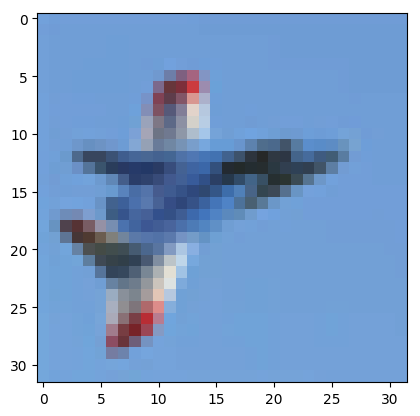

<class 'numpy.ndarray'>
(20, 32, 32, 3)
<class 'numpy.ndarray'>
(20, 1)


In [39]:
import paddle # 导入paddle库
import paddle.fluid as fluid
import numpy as np

images,labels = loadImg()

plt.imshow(images[0])
plt.show()
print(type(images))
print(images.shape)

print(type(labels))
print(labels.shape)

In [ ]:
import os, cv2
from paddle.fluid.dygraph import to_variable, save_dygraph
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image  

def test(use_gpu = True,sample = "random" ,dataSet="MNIST",meath="Mosaic",inputs=5000,classid = 5):

    if sample != "random":
        data_index = np.loadtxt("maxIndex"+str(2)+".txt", delimiter=',').astype('int32')
        data_index = paddle.to_tensor(data_index)
    else:
        data_index = np.loadtxt("randomIndex"+str(2)+".txt", delimiter=',').astype('int32')
        data_index = paddle.to_tensor(data_index)

    # 使用GPU
    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()

    with fluid.dygraph.guard(place):
        # 实例化模型
        attack1 = FCLAndAutoencoder(inputs = inputs)
        modelName = "FCLAndAutoencoder"
        savePath = os.path.join(dataSet+"_"+modelName,meath)
        model_para, _ = fluid.load_dygraph(savePath + "/"+modelName+str(classid))
        attack1.load_dict(model_para)
        attack1.eval()

        attack2 = FCLAndUNet(inputs = inputs)
        modelName = "FCLAndUNet"
        savePath = os.path.join(dataSet+"_"+modelName,meath)
        model_para, _ = fluid.load_dygraph(savePath + "/"+modelName+str(classid))
        attack2.load_dict(model_para)
        attack2.eval()

        attack3 = FCLAndMerge(inputs = inputs,a = 0.3, b =0.7)
        modelName = "merge"
        savePath = os.path.join(dataSet+"_"+modelName,meath)
        model_para, _ = fluid.load_dygraph(savePath + "/"+modelName+str(classid))
        attack3.load_dict(model_para)
        attack3.eval()

        model = MyNet(num_classes=10)
        model_para, _ = fluid.load_dygraph('Cifar10_MyNet/no/MyNet')
        model.load_dict(model_para)
        model.eval()

        print('Start testing...')

        cnt = 0
        real_imgs = paddle.to_tensor(images.astype("float32"))
        real_imgs = paddle.reshape(real_imgs,[-1,1,28,28])

        labels = paddle.to_tensor(labels.astype("float32"))
   
        gen_imgs = attack(real_imgs2)

        gen_imgs = gen_imgs.reshape((-1,28,28))

        for batch_id, data in enumerate(test_loader()):
            # 一个批量的图片[64,3,32,32]
            x_data = data[0]
            # 一个批量的标签[64]
            y_data = data[1]

            b,c,w,h = x_data.shape

            # 将y再包上一层[[64]]
            # y_data = paddle.to_tensor(data[1])
            # y_data = paddle.unsqueeze(y_data, 1)
        
            batch_grd = []
            # 遍历一个批量,计算单张图片对应的梯度
            for img,lab in zip(x_data.numpy(),y_data.numpy()):
                # 单张图片也表示成批量的形式
                image = paddle.to_tensor(np.expand_dims(img,axis = 0))
                lable = paddle.to_tensor(np.expand_dims(lab,axis = 0))
    
                # compute original gradient
                pre = model(image)
                
                avg_loss = F.cross_entropy(input=pre, label=lable)

                # avg_loss.backward()

                # dy_dx_list = []
                # for value in model.parameters():
                #     dy_dx_list.append(value.grad.detach().flatten())
                # model.clear_gradients()

                dy_dx = paddle.grad(avg_loss, model.parameters())

                # 梯度+偏置的组合
                dy_dx_list = [ paddle.flatten(x) for i,x in enumerate(dy_dx)]

                oneGrd = paddle.concat(dy_dx_list)
                model.clear_gradients()
                # print(oneGrd.shape)
                
                if sample != "random":
                    # 降序排序
                    temp_list = []
                    oneGrd = paddle.sort(oneGrd,descending = True)
                    temp_list.append(oneGrd[:2500])
                    temp_list.append(oneGrd[-2500:])
                    oneGrd = paddle.concat(temp_list)
                
                oneGrd = paddle.index_select(x=oneGrd, index=data_index)
                # print(len(dy_dx_list))
                # print(oneGrd.shape)

                batch_grd.append(oneGrd)

            Ngrd = paddle.stack(batch_grd, axis=0)
            
            # 至此便得到一个批量的图片对训练集，即 Nimg => x_data
            # =================================================================================================
            # 以下开始重构

            _,re_imag1 = attack1(Ngrd)
            _,re_imag2 = attack2(Ngrd)
            _,re_imag3 = attack3(Ngrd)

            re_imag1 = paddle.reshape(re_imag1,[b,c,w,h])
            re_imag2 = paddle.reshape(re_imag2,[b,c,w,h])
            re_imag3 = paddle.reshape(re_imag3,[b,c,w,h])
            
            for i in range(20):
                savePath = 'img1/gen_images_'+str(cnt)+'.png'
                cnt = cnt + 1
                # savePath = ""
                image_grid(x_data.numpy().transpose(0,2,3,1)[i],1,4,1,save =savePath)
                image_grid(re_imag1.numpy().transpose(0,2,3,1)[i],1,4,2,save =savePath)
                image_grid(re_imag2.numpy().transpose(0,2,3,1)[i],1,4,3,save =savePath)
                image_grid(re_imag3.numpy().transpose(0,2,3,1)[i],1,4,4,save =savePath)

                plt.show()

            if batch_id > 1:
                break;


In [71]:
import os, cv2
from paddle.fluid.dygraph import to_variable, save_dygraph
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image  

def test(use_gpu = True,sample = "random" ,dataSet="MNIST",meath="Mosaic",inputs=5000,classid = 5):

    if sample != "random":
        data_index = np.loadtxt("maxIndex"+str(2)+".txt", delimiter=',').astype('int32')
        data_index = paddle.to_tensor(data_index)
    else:
        data_index = np.loadtxt("randomIndex"+str(2)+".txt", delimiter=',').astype('int32')
        data_index = paddle.to_tensor(data_index)

    # 使用GPU
    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()

    with fluid.dygraph.guard(place):
        # 实例化模型
        attack3 = FCLAndMerge(inputs = inputs,a = 0.3, b =0.7)
        modelName = "merge"
        savePath = os.path.join(dataSet+"_"+modelName,meath)
        model_para, _ = fluid.load_dygraph(savePath + "/"+modelName+str(classid))
        attack3.load_dict(model_para)
        attack3.eval()

        model = MyNet(num_classes=10)
        model_para, _ = fluid.load_dygraph('Cifar10_MyNet/no/MyNet')
        model.load_dict(model_para)
        model.eval()

        print('Start testing...')

        cnt = 0
        real_imgs = paddle.to_tensor(images.astype("float32"))

        x_data = paddle.transpose(real_imgs,[0,3,1,2])

        y_data = paddle.to_tensor(labels.astype("int64"))

        b,c,w,h = x_data.shape

        # 将y再包上一层[[64]]
        # y_data = paddle.to_tensor(data[1])
        # y_data = paddle.unsqueeze(y_data, 1)
    
        batch_grd = []
        # 遍历一个批量,计算单张图片对应的梯度
        for img,lab in zip(x_data.numpy(),y_data.numpy()):
            # 单张图片也表示成批量的形式
            image = paddle.to_tensor(np.expand_dims(img,axis = 0))
            lable = paddle.to_tensor(np.expand_dims(lab,axis = 0))

            # compute original gradient
            pre = model(image)
            
            avg_loss = F.cross_entropy(input=pre, label=lable)

            # avg_loss.backward()

            # dy_dx_list = []
            # for value in model.parameters():
            #     dy_dx_list.append(value.grad.detach().flatten())
            # model.clear_gradients()

            dy_dx = paddle.grad(avg_loss, model.parameters())

            # 梯度+偏置的组合
            dy_dx_list = [ paddle.flatten(x) for i,x in enumerate(dy_dx)]

            oneGrd = paddle.concat(dy_dx_list)
            model.clear_gradients()
            # print(oneGrd.shape)
            
            if sample != "random":
                # 降序排序
                temp_list = []
                oneGrd = paddle.sort(oneGrd,descending = True)
                temp_list.append(oneGrd[:2500])
                temp_list.append(oneGrd[-2500:])
                oneGrd = paddle.concat(temp_list)
            
            oneGrd = paddle.index_select(x=oneGrd, index=data_index)
            # print(len(dy_dx_list))
            # print(oneGrd.shape)

            batch_grd.append(oneGrd)

        Ngrd = paddle.stack(batch_grd, axis=0)
        
        # 至此便得到一个批量的图片对训练集，即 Nimg => x_data
        # =================================================================================================
        # 以下开始重构

        _,re_imag3 = attack3(Ngrd)

        re_imag3 = paddle.reshape(re_imag3,[b,c,w,h])
        
        for i in range(20):
            # savePath = 'img1/gen_images_'+str(cnt)+'.png'
            savePath = ""
            cnt = cnt + 1
            # savePath = ""
            aa = x_data.numpy().transpose(0,2,3,1)[i]
            image_grid(aa,1,3,1,save =savePath)

            plt.subplot(1,3,2)
            canvas = np.zeros((28, 28), np.uint8)
            canvas_1 = 255 - canvas

            plt.imshow(canvas_1,cmap = 'gray',  interpolation = 'none', vmin=0, vmax=255)
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            
            bb = re_imag3.numpy().transpose(0,2,3,1)[i]
            image_grid(bb,1,3,3,save =savePath)
            
            print("psnr is {}".format(psnr(aa,bb,1.0)))
            print("ssim is {}".format(ssim(aa,bb,1.0)))
            plt.show()


In [30]:
from util import *
echo("aaaaa")

aaaaa


Start testing...
mse is 0.024197222664952278
psnr is 16.162344790817656
ssim is 0.22676633183712003
mse is 0.12841077148914337
psnr is 8.913985447867221
ssim is 0.03964905405304754


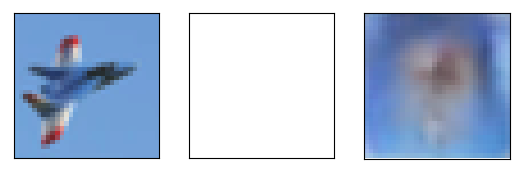

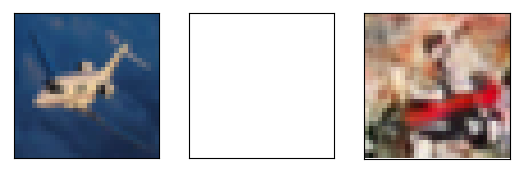

In [73]:
test(sample = "random",dataSet="Cifar10",meath="class_lable",inputs=5000,classid=5)

In [ ]:

#加拉普拉斯噪声，默认为原始数据添加μ为0，b为1的噪声
def add_laplace_noise(data_array, μ=0, b=0.01):
    # shp = data_array.shape
    # temp = data_array.flatten()
    # laplace_noise = np.random.laplace(μ, b, len(temp))
    # temp += laplace_noise
    # data_array = temp.reshape(shp)
    # print(data_array)
    return data_array

def get_psnr2(img1, img2):
   mse = np.mean((img1/1.0 - img2/1.0) ** 2 )
   if mse < 1.0e-10:
      return 100
   return 10 * np.math.log10(1.0 / mse)


for imidx in range(num_dummy):
    idx = idx_shuffle[imidx]
    imidx_list.append(idx)
    tmp_datum = tt(dst[idx][0]).float().to(device)
    tmp_datum = tmp_datum.view(1, *tmp_datum.size())
    tmp_label = torch.Tensor([dst[idx][1]]).long().to(device)
    tmp_label = tmp_label.view(1, )
    if imidx == 0:
        gt_data = tmp_datum
        gt_label = tmp_label
    else:
        gt_data = torch.cat((gt_data, tmp_datum), dim=0)
        gt_label = torch.cat((gt_label, tmp_label), dim=0)


# compute original gradient
out = net(gt_data)
y = criterion(out, gt_label)
dy_dx = torch.autograd.grad(y, net.parameters())
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

restruct_grad = []
for i in range(len(original_dy_dx)):
    tem = original_dy_dx[i].cpu().numpy()
    # print(tem[:10])
    restruct_grad.append(torch.from_numpy(add_laplace_noise(tem)).to(device))

# print(type(restruct_grad))
# print(len(restruct_grad))

# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn((gt_data.shape[0], num_classes)).to(device).requires_grad_(True)

if method == 'DLG':
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label], lr=lr)
elif method == 'iDLG':
    optimizer = torch.optim.LBFGS([dummy_data, ], lr=lr)
    # predict the ground-truth label
    label_pred = torch.argmin(torch.sum(restruct_grad[-2], dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)


if method == 'DLG':
    dummy_loss = - torch.mean(torch.sum(torch.softmax(dummy_label, -1) * torch.log(torch.softmax(pred, -1)), dim=-1))
    # dummy_loss = criterion(pred, gt_label)
elif method == 'iDLG':
    dummy_loss = criterion(pred, label_pred)

dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

grad_diff = 0
for gx, gy in zip(dummy_dy_dx, restruct_grad):
    grad_diff += ((gx - gy) ** 2).sum()
grad_diff.backward()
return grad_diff


for imidx in range(num_dummy):
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 10, 1)
    plt.imshow(tp(gt_data[imidx].cpu()))
    # plt.show()
    for i in range(min(len(history), 29)):
        plt.subplot(3, 10, i + 2)
        plt.imshow(history[i][imidx])

        psnr.append(get_psnr2(dummy_data[imidx].detach().cpu().numpy(),gt_data[imidx].cpu().numpy()))
        f = open("psnr"+str(idx_net)+".txt", "w")
        f.writelines(str(psnr))
        f.close()

        plt.title('iter=%d' % (history_iters[i]))
        plt.axis('off')
        # plt.show()
    if method == 'DLG':
        plt.savefig('%s/DLG_on_%s_%05d.png' % (save_path, imidx_list, imidx_list[imidx]))
        plt.close()
    elif method == 'iDLG':
        plt.savefig('%s/iDLG_on_%s_%05d.png' % (save_path, imidx_list, imidx_list[imidx]))
        plt.close()

if current_loss < 0.000001: # converge
    break

if __name__ == '__main__':
    main()

NameError: name 'num_dummy' is not defined

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 